# NFL Game Prediction — Logistic Regression vs Decision Tree

## Why Logistic Regression Outperforms Decision Trees at Predicting Game Winners

This notebook:
1. **Builds prior-only features** to avoid data leakage (no peeking at game outcomes!)
2. **Trains two models** (Logistic Regression & Decision Tree) using walk-forward validation
3. **Compares performance** across 4 key metrics: Accuracy, Brier Score, Log Loss, and AUC
4. **Predicts tonight's TNF game** (Jets @ Patriots) using both models

**Key Finding:** Logistic Regression produces well-calibrated probabilities, while Decision Trees give extreme predictions that hurt performance.

# NFL Game Prediction Model - Prior Features Only (No Data Leakage)

This notebook builds a predictive model using **only prior game statistics** to avoid data leakage.

All features end with `_prior` suffix and are calculated from games **before** the target game.


In [1]:
# Import libraries
import nflreadpy as nfl
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler


In [2]:
# ============================================================================
# STEP 1: Load NFL datasets
# ============================================================================
print("Loading NFL data...")
team_stats = nfl.load_team_stats([2021, 2022, 2023, 2024, 2025]).to_pandas()
schedules = nfl.load_schedules([2021, 2022, 2023, 2024, 2025]).to_pandas()
player_stats = nfl.load_player_stats([2021, 2022, 2023, 2024, 2025]).to_pandas()
ff_rankings = nfl.load_ff_rankings().to_pandas()
print("✓ Data loaded successfully")


Loading NFL data...
✓ Data loaded successfully


In [3]:
# ============================================================================
# STEP 2: Create PRIOR GAME features (no data leakage!)
# ============================================================================
# These features only use data from games BEFORE the current game

print("\nBuilding prior features...")

# Start with completed regular season games
completed_games = schedules[schedules['game_type'] == 'REG'].dropna(subset=['home_score', 'away_score']).copy()

# Prepare game-level stats
game_stats = team_stats[['season', 'week', 'team', 
                          'passing_yards', 'rushing_yards', 'passing_interceptions',
                          'def_interceptions', 'sacks_suffered', 'rushing_fumbles_lost',
                          'receiving_fumbles_lost', 'sack_fumbles_lost', 'def_fumbles',
                          'penalty_yards', 'attempts', 'carries']].copy()

# Calculate derived metrics at game level
game_stats['total_fumbles_lost'] = (
    game_stats['rushing_fumbles_lost'] + 
    game_stats['receiving_fumbles_lost'] + 
    game_stats['sack_fumbles_lost']
)

game_stats['total_plays'] = game_stats['attempts'] + game_stats['carries']
game_stats['total_yards'] = game_stats['passing_yards'] + game_stats['rushing_yards']
game_stats['yards_per_play'] = game_stats['total_yards'] / game_stats['total_plays'].replace(0, 1)

game_stats['turnovers_forced'] = game_stats['def_interceptions'] + game_stats['def_fumbles']
game_stats['turnovers_committed'] = game_stats['passing_interceptions'] + game_stats['total_fumbles_lost']
game_stats['turnover_diff'] = game_stats['turnovers_forced'] - game_stats['turnovers_committed']

# Sort by season and week to ensure temporal ordering
game_stats = game_stats.sort_values(['season', 'week']).reset_index(drop=True)
completed_games = completed_games.sort_values(['season', 'week']).reset_index(drop=True)

# ============================================================================
# Calculate cumulative PRIOR stats for each team at each game
# ============================================================================

def calculate_prior_features(df, team_col, season_col='season', week_col='week'):
    """
    Calculate cumulative statistics from all prior games for each team.
    Returns a dataframe with one row per team-season-week combo.
    """
    df = df.sort_values([season_col, week_col]).reset_index(drop=True)
    
    # Features to calculate rolling means for
    stat_cols = [
        'passing_yards', 'rushing_yards', 'passing_interceptions',
        'def_interceptions', 'sacks_suffered', 'total_fumbles_lost',
        'def_fumbles', 'penalty_yards', 'yards_per_play', 'turnover_diff'
    ]
    
    results = []
    
    # Group by season and team
    for (season, team), group in df.groupby([season_col, team_col]):
        group = group.sort_values(week_col).reset_index(drop=True)
        
        for idx, row in group.iterrows():
            current_week = row[week_col]
            
            # Get all prior games (exclude current game)
            prior_games = group[group[week_col] < current_week]
            
            if len(prior_games) == 0:
                # First game of season - use neutral priors
                prior_stats = {f'{col}_prior': 0.0 for col in stat_cols}
                prior_stats['games_played_prior'] = 0
            else:
                # Calculate cumulative averages from all prior games
                prior_stats = {f'{col}_prior': prior_games[col].mean() for col in stat_cols}
                prior_stats['games_played_prior'] = len(prior_games)
            
            result = {
                'season': season,
                'team': team,
                'week': current_week,
                **prior_stats
            }
            results.append(result)
    
    return pd.DataFrame(results)

# Calculate prior features for all teams
team_prior_features = calculate_prior_features(game_stats, 'team')

# ============================================================================
# Add win percentage and scoring stats from schedules
# ============================================================================

# Create a record of each team's games with outcomes
home_games = completed_games[['season', 'week', 'home_team', 'home_score', 'away_score']].copy()
home_games['team'] = home_games['home_team']
home_games['points_for'] = home_games['home_score']
home_games['points_against'] = home_games['away_score']
home_games['won'] = (home_games['home_score'] > home_games['away_score']).astype(int)

away_games = completed_games[['season', 'week', 'away_team', 'away_score', 'home_score']].copy()
away_games['team'] = away_games['away_team']
away_games['points_for'] = away_games['away_score']
away_games['points_against'] = away_games['home_score']
away_games['won'] = (away_games['away_score'] > away_games['home_score']).astype(int)

# Combine all games
all_team_games = pd.concat([
    home_games[['season', 'week', 'team', 'points_for', 'points_against', 'won']],
    away_games[['season', 'week', 'team', 'points_for', 'points_against', 'won']]
]).sort_values(['season', 'week']).reset_index(drop=True)

# Calculate cumulative win% and scoring stats
scoring_prior_features = []

for (season, team), group in all_team_games.groupby(['season', 'team']):
    group = group.sort_values('week').reset_index(drop=True)
    
    for idx, row in group.iterrows():
        current_week = row['week']
        prior_games = group[group['week'] < current_week]
        
        if len(prior_games) == 0:
            # First game - use neutral priors
            win_pct_prior = 0.5
            avg_points_for_prior = 0.0
            avg_points_against_prior = 0.0
            avg_scoring_margin_prior = 0.0
        else:
            win_pct_prior = prior_games['won'].mean()
            avg_points_for_prior = prior_games['points_for'].mean()
            avg_points_against_prior = prior_games['points_against'].mean()
            avg_scoring_margin_prior = avg_points_for_prior - avg_points_against_prior
        
        scoring_prior_features.append({
            'season': season,
            'team': team,
            'week': current_week,
            'win_pct_prior': win_pct_prior,
            'avg_points_for_prior': avg_points_for_prior,
            'avg_points_against_prior': avg_points_against_prior,
            'avg_scoring_margin_prior': avg_scoring_margin_prior
        })

scoring_prior_df = pd.DataFrame(scoring_prior_features)

# Merge scoring stats
team_prior_features = team_prior_features.merge(
    scoring_prior_df, on=['season', 'team', 'week'], how='left'
)

# ============================================================================
# Add QB stats (using prior games only)
# ============================================================================

qb_prior_list = []
qb_game_data = player_stats[player_stats["position"] == "QB"][
    ['season', 'week', 'team', 'passing_yards']
].copy()

for (season, team), group in qb_game_data.groupby(['season', 'team']):
    group = group.sort_values('week').reset_index(drop=True)
    
    for idx, row in group.iterrows():
        current_week = row['week']
        prior_games = group[group['week'] < current_week]
        
        if len(prior_games) == 0:
            avg_qb_passing_yards_prior = 0.0
        else:
            avg_qb_passing_yards_prior = prior_games['passing_yards'].mean()
        
        qb_prior_list.append({
            'season': season,
            'team': team,
            'week': current_week,
            'avg_qb_passing_yards_prior': avg_qb_passing_yards_prior
        })

qb_prior_df = pd.DataFrame(qb_prior_list)

team_prior_features = team_prior_features.merge(
    qb_prior_df, on=['season', 'team', 'week'], how='left'
)

# ============================================================================
# Add fantasy football rankings
# ============================================================================

ff_strength = (
    ff_rankings.groupby("team")
    .agg({"ecr": "mean"})
    .reset_index()
    .rename(columns={"ecr": "avg_ff_rank_prior"})
)

team_prior_features = team_prior_features.merge(
    ff_strength, on='team', how='left'
)

# ============================================================================
# Calculate Strength of Schedule (prior games only)
# ============================================================================

sos_prior_list = []

for (season, team), group in all_team_games.groupby(['season', 'team']):
    group = group.sort_values('week').reset_index(drop=True)
    
    for idx, row in group.iterrows():
        current_week = row['week']
        
        if current_week == group['week'].min():
            # First game - no prior opponents
            avg_sos_prior = 0.5
        else:
            # Find opponents from prior weeks
            home_opponents = completed_games[
                (completed_games['season'] == season) & 
                (completed_games['home_team'] == team) & 
                (completed_games['week'] < current_week)
            ]['away_team'].tolist()
            
            away_opponents = completed_games[
                (completed_games['season'] == season) & 
                (completed_games['away_team'] == team) & 
                (completed_games['week'] < current_week)
            ]['home_team'].tolist()
            
            all_opponents = home_opponents + away_opponents
            
            if len(all_opponents) == 0:
                avg_sos_prior = 0.5
            else:
                # Get win% of these opponents up to when they were faced
                opponent_win_pcts = []
                for opp in all_opponents:
                    opp_prior_games = all_team_games[
                        (all_team_games['season'] == season) &
                        (all_team_games['team'] == opp) &
                        (all_team_games['week'] < current_week)
                    ]
                    if len(opp_prior_games) > 0:
                        opp_win_pct = opp_prior_games['won'].mean()
                    else:
                        opp_win_pct = 0.5
                    opponent_win_pcts.append(opp_win_pct)
                
                avg_sos_prior = np.mean(opponent_win_pcts) if opponent_win_pcts else 0.5
        
        sos_prior_list.append({
            'season': season,
            'team': team,
            'week': current_week,
            'avg_sos_prior': avg_sos_prior
        })

sos_prior_df = pd.DataFrame(sos_prior_list)

team_prior_features = team_prior_features.merge(
    sos_prior_df, on=['season', 'team', 'week'], how='left'
)

# ============================================================================
# Display summary
# ============================================================================

print("\n" + "="*80)
print("PRIOR FEATURES (No Data Leakage!)")
print("="*80)
print(f"\nTotal records: {len(team_prior_features):,}")
print(f"Seasons covered: {team_prior_features['season'].min()} - {team_prior_features['season'].max()}")
print(f"Teams: {team_prior_features['team'].nunique()}")

print("\nFeature List:")
feature_cols = [c for c in team_prior_features.columns if c.endswith('_prior')]
for i, col in enumerate(feature_cols, 1):
    print(f"   {i:2d}. {col}")

print("\n✓ All features use ONLY data from games prior to the current game")
print("✓ No data leakage - safe to use for prediction!")

print("\nSample data:")

display(team_prior_features.head(10))



Building prior features...

PRIOR FEATURES (No Data Leakage!)

Total records: 3,096
Seasons covered: 2021 - 2025
Teams: 32

Feature List:
    1. passing_yards_prior
    2. rushing_yards_prior
    3. passing_interceptions_prior
    4. def_interceptions_prior
    5. sacks_suffered_prior
    6. total_fumbles_lost_prior
    7. def_fumbles_prior
    8. penalty_yards_prior
    9. yards_per_play_prior
   10. turnover_diff_prior
   11. games_played_prior
   12. win_pct_prior
   13. avg_points_for_prior
   14. avg_points_against_prior
   15. avg_scoring_margin_prior
   16. avg_qb_passing_yards_prior
   17. avg_ff_rank_prior
   18. avg_sos_prior

✓ All features use ONLY data from games prior to the current game
✓ No data leakage - safe to use for prediction!

Sample data:


,season,team,week,passing_yards_prior,rushing_yards_prior,passing_interceptions_prior,def_interceptions_prior,sacks_suffered_prior,total_fumbles_lost_prior,def_fumbles_prior,...,yards_per_play_prior,turnover_diff_prior,games_played_prior,win_pct_prior,avg_points_for_prior,avg_points_against_prior,avg_scoring_margin_prior,avg_qb_passing_yards_prior,avg_ff_rank_prior,avg_sos_prior
0,2021,ARI,1,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0,0.5,0.000000,0.000000,0.000000,0.000,126.289494,0.500000
1,2021,ARI,2,289.000000,136.000000,1.000000,1.0,2.000000,0.000000,0.000000,...,6.538462,0.000000,1,1.0,38.000000,13.000000,25.000000,289.000,126.289494,0.000000
2,2021,ARI,3,344.500000,119.500000,1.500000,0.5,2.500000,0.000000,0.000000,...,7.681511,-1.000000,2,1.0,36.000000,23.000000,13.000000,344.500,126.289494,0.250000
3,2021,ARI,4,335.000000,110.000000,1.333333,1.0,1.666667,0.000000,0.333333,...,7.240799,0.000000,3,1.0,34.333333,21.666667,12.666667,335.000,126.289494,0.333333
4,2021,ARI,4,335.000000,110.000000,1.333333,1.0,1.666667,0.000000,0.333333,...,7.240799,0.000000,3,1.0,34.333333,21.666667,12.666667,335.000,126.289494,0.333333
5,2021,ARI,5,318.250000,136.500000,1.000000,1.0,2.000000,0.000000,0.250000,...,7.111155,0.250000,4,1.0,35.000000,21.250000,13.750000,254.600,126.289494,0.375000
6,2021,ARI,6,302.400000,128.000000,0.800000,1.0,2.000000,0.200000,0.200000,...,6.837200,0.200000,5,1.0,31.400000,19.000000,12.400000,252.000,126.289494,0.440000
7,2021,ARI,6,302.400000,128.000000,0.800000,1.0,2.000000,0.200000,0.200000,...,6.837200,0.200000,5,1.0,31.400000,19.000000,12.400000,252.000,126.289494,0.440000
8,2021,ARI,7,290.166667,130.666667,0.666667,1.0,2.000000,0.166667,0.166667,...,6.625527,0.333333,6,1.0,32.333333,18.166667,14.166667,217.625,126.289494,0.511111
9,2021,ARI,7,290.166667,130.666667,0.666667,1.0,2.000000,0.166667,0.166667,...,6.625527,0.333333,6,1.0,32.333333,18.166667,14.166667,217.625,126.289494,0.511111


In [4]:
# ============================================================================
# STEP 3: Create modeling dataset
# ============================================================================

print("\nCreating modeling dataset...")

# Filter to regular season completed games only
games = completed_games.copy()

# Merge home team prior features
games = games.merge(
    team_prior_features.add_prefix("home_"),
    left_on=["season", "week", "home_team"],
    right_on=["home_season", "home_week", "home_team"],
    how="left"
)

# Merge away team prior features
games = games.merge(
    team_prior_features.add_prefix("away_"),
    left_on=["season", "week", "away_team"],
    right_on=["away_season", "away_week", "away_team"],
    how="left"
)

# Create target variable
games["home_team_win"] = (games["home_score"] > games["away_score"]).astype(int)

# Select feature columns
base_cols = ["season", "week", "home_team", "away_team", "home_team_win"]
home_feature_cols = sorted([col for col in games.columns if col.startswith("home_") and col.endswith("_prior")])
away_feature_cols = sorted([col for col in games.columns if col.startswith("away_") and col.endswith("_prior")])

model_df = games[base_cols + home_feature_cols + away_feature_cols].dropna()

# Compute feature differences (home - away)
diff_features = [
    c.replace("home_", "diff_")
    for c in model_df.columns if c.startswith("home_") and c.endswith("_prior")
]

for hf, af, df in zip(
    [c for c in model_df.columns if c.startswith("home_") and c.endswith("_prior")],
    [c for c in model_df.columns if c.startswith("away_") and c.endswith("_prior")],
    diff_features
):
    model_df[df] = model_df[hf] - model_df[af]

# Select features and target
X = model_df[diff_features]
y = model_df["home_team_win"]

print("\n" + "="*80)
print("Modeling Dataset Summary")
print("="*80)
print(model_df.head())
print(f"Total games: {len(model_df):,}")
print(f"Features: {len(diff_features)}")
print(f"Home team win rate: {y.mean():.3f}")

print("\nFeature differences (home - away):")
for i, col in enumerate(diff_features, 1):
    print(f"   {i:2d}. {col}")

print("\nSample features:")
display(X.head())



Creating modeling dataset...

Modeling Dataset Summary
   season  week home_team away_team  home_team_win  home_avg_ff_rank_prior  \
0    2021     1        TB       DAL              1              105.259057   
1    2021     1       ATL       PHI              0              115.436923   
2    2021     1       BUF       PIT              0              114.407879   
3    2021     1       CAR       NYJ              1              119.503203   
4    2021     1       CIN       MIN              1              131.279483   

   home_avg_points_against_prior  home_avg_points_for_prior  \
0                            0.0                        0.0   
1                            0.0                        0.0   
2                            0.0                        0.0   
3                            0.0                        0.0   
4                            0.0                        0.0   

   home_avg_qb_passing_yards_prior  home_avg_scoring_margin_prior  ...  \
0                     

,diff_avg_ff_rank_prior,diff_avg_points_against_prior,diff_avg_points_for_prior,diff_avg_qb_passing_yards_prior,diff_avg_scoring_margin_prior,diff_avg_sos_prior,diff_def_fumbles_prior,diff_def_interceptions_prior,diff_games_played_prior,diff_passing_interceptions_prior,diff_passing_yards_prior,diff_penalty_yards_prior,diff_rushing_yards_prior,diff_sacks_suffered_prior,diff_total_fumbles_lost_prior,diff_turnover_diff_prior,diff_win_pct_prior,diff_yards_per_play_prior
0,-14.949515,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.333588,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.582919,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-5.181455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,26.807247,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# ============================================================================
# STEP 4: Train/Test Split
# ============================================================================

# Split the data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\n" + "="*80)
print("Train/Test Split")
print("="*80)
print(f"Training set size: {len(X_train):,}")
print(f"Testing set size: {len(X_test):,}")
print(f"Training set home win rate: {y_train.mean():.3f}")
print(f"Testing set home win rate: {y_test.mean():.3f}")

# Scale the features (important for logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✓ Features scaled using StandardScaler")



Train/Test Split
Training set size: 1,294
Testing set size: 324
Training set home win rate: 0.557
Testing set home win rate: 0.559

✓ Features scaled using StandardScaler


In [6]:
# ============================================================================
# STEP 5: L1 Regularization for Feature Selection
# ============================================================================

print("\n" + "="*80)
print("L1 REGULARIZATION - FEATURE SELECTION")
print("="*80)

# Get feature names
feature_names = X.columns.tolist()

# Train L1 logistic regression
log_reg_l1 = LogisticRegression(
    penalty='l1',
    solver='liblinear',  
    C=1.0,              
    max_iter=1000,
    random_state=42
)

log_reg_l1.fit(X_train_scaled, y_train)

# Get coefficients and identify selected features
coeffs = log_reg_l1.coef_.flatten()
selected_mask = coeffs != 0
selected_features = np.array(feature_names)[selected_mask]
dropped_features = np.array(feature_names)[~selected_mask]

# Display results
print(f"\nSelected features ({len(selected_features)}):")
for i, (feat, coef) in enumerate(zip(selected_features, coeffs[selected_mask]), 1):
    print(f"  {i:2d}. {feat:40s} → {coef:7.4f}")

print(f"\nDropped features ({len(dropped_features)}):")
for feat in dropped_features:
    print(f"  - {feat}")

# Evaluate performance
y_train_pred = log_reg_l1.predict(X_train_scaled)
y_test_pred = log_reg_l1.predict(X_test_scaled)
y_train_proba = log_reg_l1.predict_proba(X_train_scaled)[:, 1]
y_test_proba = log_reg_l1.predict_proba(X_test_scaled)[:, 1]

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
train_auc = roc_auc_score(y_train, y_train_proba)
test_auc = roc_auc_score(y_test, y_test_proba)

print("\n" + "="*80)
print("UPDATED MODEL PERFORMANCE")
print("="*80)
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Testing Accuracy:  {test_acc:.4f}")

print("\n" + "="*80)
print("Classification Report (Test Set)")
print("="*80)
print(classification_report(y_test, y_test_pred, target_names=['Away Win', 'Home Win']))

print("\n" + "="*80)
print("Confusion Matrix (Test Set)")
print("="*80)
cm = confusion_matrix(y_test, y_test_pred)
print(f"\n                Predicted")
print(f"                Away  Home")
print(f"Actual Away     {cm[0,0]:4d}  {cm[0,1]:4d}")
print(f"       Home     {cm[1,0]:4d}  {cm[1,1]:4d}")



L1 REGULARIZATION - FEATURE SELECTION

Selected features (16):
   1. diff_avg_ff_rank_prior                   → -0.1005
   2. diff_avg_points_for_prior                →  0.0637
   3. diff_avg_qb_passing_yards_prior          →  0.0591
   4. diff_avg_scoring_margin_prior            →  0.1210
   5. diff_avg_sos_prior                       →  0.2132
   6. diff_def_fumbles_prior                   → -0.0241
   7. diff_def_interceptions_prior             →  0.1891
   8. diff_games_played_prior                  → -0.0367
   9. diff_passing_interceptions_prior         →  0.0996
  10. diff_passing_yards_prior                 →  0.0139
  11. diff_penalty_yards_prior                 →  0.0336
  12. diff_rushing_yards_prior                 →  0.0397
  13. diff_sacks_suffered_prior                → -0.2630
  14. diff_total_fumbles_lost_prior            →  0.1817
  15. diff_win_pct_prior                       →  0.1602
  16. diff_yards_per_play_prior                →  0.3576

Dropped features (2):
 

In [7]:
# ============================================================================
# STEP 6: Display Coefficients Sorted by Magnitude
# ============================================================================

coef_df = (
    pd.DataFrame({
        "Feature": feature_names,
        "Coefficient": coeffs
    })
    .query("Coefficient != 0")  # keep only selected features
    .assign(AbsCoeff=lambda d: d["Coefficient"].abs())  # magnitude for sorting
    .sort_values("AbsCoeff", ascending=False)
    .drop(columns=['AbsCoeff'])
    .reset_index(drop=True)
)

print("\n" + "="*80)
print("COEFFICIENTS FOR SELECTED FEATURES (sorted by magnitude)")
print("="*80)
display(coef_df)



COEFFICIENTS FOR SELECTED FEATURES (sorted by magnitude)


,Feature,Coefficient
0,diff_yards_per_play_prior,0.357622
1,diff_sacks_suffered_prior,-0.263028
2,diff_avg_sos_prior,0.213170
3,diff_def_interceptions_prior,0.189127
4,diff_total_fumbles_lost_prior,0.181734
5,diff_win_pct_prior,0.160172
6,diff_avg_scoring_margin_prior,0.121020
7,diff_avg_ff_rank_prior,-0.100460
8,diff_passing_interceptions_prior,0.099612
9,diff_avg_points_for_prior,0.063725


---
## Part 2: Walk-Forward Model Comparison

Now let's compare **Logistic Regression** and **Decision Tree** models using **walk-forward validation** to see which performs better at predicting NFL game winners.


In [8]:
# ============================================================================
# Prepare variables for walk-forward comparison (Cells 15+)
# ============================================================================
# Create the expected variable names from the existing model_df

# Sort by season and week for temporal ordering
model_df_sorted = model_df.sort_values(['season', 'week']).reset_index(drop=True)

# Create baseline diff feature column list
diff_feature_cols_base = [col for col in model_df.columns if col.startswith('diff_') and col.endswith('_prior')]

print(f"✓ Created model_df_sorted with {len(model_df_sorted)} games")
print(f"✓ Created diff_feature_cols_base with {len(diff_feature_cols_base)} features")
print(f"\nFeatures: {diff_feature_cols_base}")


✓ Created model_df_sorted with 1618 games
✓ Created diff_feature_cols_base with 18 features

Features: ['diff_avg_ff_rank_prior', 'diff_avg_points_against_prior', 'diff_avg_points_for_prior', 'diff_avg_qb_passing_yards_prior', 'diff_avg_scoring_margin_prior', 'diff_avg_sos_prior', 'diff_def_fumbles_prior', 'diff_def_interceptions_prior', 'diff_games_played_prior', 'diff_passing_interceptions_prior', 'diff_passing_yards_prior', 'diff_penalty_yards_prior', 'diff_rushing_yards_prior', 'diff_sacks_suffered_prior', 'diff_total_fumbles_lost_prior', 'diff_turnover_diff_prior', 'diff_win_pct_prior', 'diff_yards_per_play_prior']


In [9]:
# Select feature source (shrunk if available, else baseline) and ensure folds
import numpy as np
import pandas as pd
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.preprocessing import StandardScaler

# Detect modeling frames created earlier in the notebook
if 'model_df_shrunk_sorted' in globals() and 'diff_feature_cols_shrunk' in globals():
    _df = model_df_shrunk_sorted.copy()
    _features = diff_feature_cols_shrunk[:]
    print('Using shrunk-prior features for both models.')
elif 'model_df_sorted' in globals() and 'diff_feature_cols_base' in globals():
    _df = model_df_sorted.copy()
    _features = [c for c in diff_feature_cols_base if 'ff_rank' not in c.lower()]
    print('Using baseline diff features for both models.')
else:
    raise NameError('Expected model_df_shrunk_sorted/diff_feature_cols_shrunk or model_df_sorted/diff_feature_cols_base from earlier cells.')

# Ensure time ordering
_df = _df.sort_values(['season','week']).reset_index(drop=True)

def brier_score(y_true, y_prob):
    y_true = np.asarray(y_true).astype(float)
    y_prob = np.asarray(y_prob).astype(float)
    return np.mean((y_true - y_prob) ** 2)

unique_weeks = sorted(set(zip(_df['season'], _df['week'])))

def make_folds(df, min_train_games=64):
    folds = []
    for season, week in unique_weeks:
        tr_mask = ((df['season'] < season) | ((df['season']==season) & (df['week'] < week)))
        te_mask = ((df['season']==season) & (df['week']==week))
        if tr_mask.sum() >= min_train_games and te_mask.sum() > 0:
            folds.append({
                'season': season, 'week': week,
                'train_idx': np.where(tr_mask)[0],
                'test_idx': np.where(te_mask)[0]
            })
    return folds

_folds = make_folds(_df)
print(f'Folds created: {len(_folds)} weeks; total test games =', sum(len(f["test_idx"]) for f in _folds))


Using baseline diff features for both models.
Folds created: 78 weeks; total test games = 1542


In [10]:
# Generic walk-forward runner (model provided by factory)
def run_walk_forward_model(df, feature_cols, folds, make_model, needs_scaler=True):
    rows = []
    for f in folds:
        season, week = f['season'], f['week']
        tr, te = f['train_idx'], f['test_idx']
        X_tr = df.iloc[tr][feature_cols].values
        y_tr = df.iloc[tr]['home_team_win'].values
        X_te = df.iloc[te][feature_cols].values
        y_te = df.iloc[te]['home_team_win'].values
        if needs_scaler:
            scaler = StandardScaler().fit(X_tr)
            X_tr_s = scaler.transform(X_tr); X_te_s = scaler.transform(X_te)
        else:
            X_tr_s, X_te_s = X_tr, X_te
        model = make_model(X_tr_s, y_tr, season, week)
        proba = model.predict_proba(X_te_s)[:,1]
        pred = (proba >= 0.5).astype(int)
        meta = df.iloc[te][['season','week','home_team','away_team']].reset_index(drop=True)
        for i in range(len(te)):
            rows.append({
                'season': int(meta.loc[i,'season']), 'week': int(meta.loc[i,'week']),
                'home_team': meta.loc[i,'home_team'], 'away_team': meta.loc[i,'away_team'],
                'y_true': int(y_te[i]), 'proba_home': float(proba[i]), 'pred_home': int(pred[i])
            })
    return pd.DataFrame(rows)


In [11]:
# Walk-Forward Model 1: Logistic Regression (per-fold tuning with a small, last-10% validation)
from sklearn.linear_model import LogisticRegression
def make_logit(X_tr, y_tr, season, week):
    C_grid = [0.05, 0.1, 0.2, 0.5, 1.0]
    penalties = ['l1','l2']
    best = ('l1', 1.0, 'liblinear', 1e9)
    n = len(X_tr)
    val_start = max(int(n*0.9), n-50)
    X_in, y_in = X_tr[:val_start], y_tr[:val_start]
    X_val, y_val = X_tr[val_start:], y_tr[val_start:]
    if len(X_val) >= 8:
        for p in penalties:
            solver = 'liblinear' if p=='l1' else 'lbfgs'
            for C in C_grid:
                lr = LogisticRegression(penalty=p, C=C, solver=solver, max_iter=2000, random_state=42)
                lr.fit(X_in, y_in)
                proba = lr.predict_proba(X_val)[:,1]
                score = ((y_val - proba)**2).mean()
                if score < best[3]:
                    best = (p, C, solver, score)
    lr = LogisticRegression(penalty=best[0], C=best[1], solver=best[2], max_iter=2000, random_state=42)
    lr.fit(X_tr, y_tr)
    return lr

print('Running Logistic (walk-forward)...')
wf_logit = run_walk_forward_model(_df, _features, _folds, make_logit, needs_scaler=True)


Running Logistic (walk-forward)...


In [12]:
# Walk-Forward Model 2: Decision Tree (per-fold tuning; no scaling)
from sklearn.tree import DecisionTreeClassifier
def make_tree(X_tr, y_tr, season, week):
    depth_grid = [3, 4, 5, 6, 8, 10, None]
    leaf_grid = [1, 2, 5, 10, 20]
    best = (None, 1, 1e9)
    n = len(X_tr)
    val_start = max(int(n*0.9), n-50)
    X_in, y_in = X_tr[:val_start], y_tr[:val_start]
    X_val, y_val = X_tr[val_start:], y_tr[val_start:]
    if len(X_val) >= 8:
        for d in depth_grid:
            for l in leaf_grid:
                dt = DecisionTreeClassifier(max_depth=d, min_samples_leaf=l, random_state=42)
                dt.fit(X_in, y_in)
                proba = dt.predict_proba(X_val)[:,1]
                score = ((y_val - proba)**2).mean()
                if score < best[2]:
                    best = (d, l, score)
    dt = DecisionTreeClassifier(max_depth=best[0], min_samples_leaf=best[1], random_state=42)
    dt.fit(X_tr, y_tr)
    return dt

print('Running Decision Tree (walk-forward)...')
wf_tree = run_walk_forward_model(_df, _features, _folds, make_tree, needs_scaler=False)


Running Decision Tree (walk-forward)...


In [13]:
# Summaries
def summarize(df):
    acc = (df['pred_home']==df['y_true']).mean()
    brier = brier_score(df['y_true'].values, df['proba_home'].values)
    ll = log_loss(df['y_true'].values, df['proba_home'].values, labels=[0,1])
    try:
        auc = roc_auc_score(df['y_true'].values, df['proba_home'].values)
    except Exception:
        auc = float('nan')
    return acc, brier, ll, auc

acc_L, brier_L, ll_L, auc_L = summarize(wf_logit)
acc_T, brier_T, ll_T, auc_T = summarize(wf_tree)
print('Logistic:', acc_L, brier_L, ll_L, auc_L)
print('Tree    :', acc_T, brier_T, ll_T, auc_T)

# Save per-game predictions for auditing / scripts
wf_logit.to_csv('wf_logit_predictions.csv', index=False)
wf_tree.to_csv('wf_tree_predictions.csv', index=False)
print('Saved: wf_logit_predictions.csv, wf_tree_predictions.csv')


Logistic: 0.6277561608300908 0.22857263138404885 0.6493713126252852 0.665439268545832
Tree    : 0.6128404669260701 0.2729318252786744 2.9581343037576757 0.628093248115372
Saved: wf_logit_predictions.csv, wf_tree_predictions.csv


In [ ]:
# ============================================================================
# PREDICT UPCOMING TNF GAME: New York Jets @ New England Patriots
# ============================================================================

home_team = "NE"   # New England Patriots (home)
away_team = "NYJ"  # New York Jets (away)
season_year = 2024

print("="*80)
print(f"🏈 GAME PREDICTION: {away_team} @ {home_team}")
print("="*80)

# Get latest data for both teams in 2024 season
home_data = team_prior_features[
    (team_prior_features['team'] == home_team) & 
    (team_prior_features['season'] == season_year)
].sort_values('week', ascending=False)

away_data = team_prior_features[
    (team_prior_features['team'] == away_team) & 
    (team_prior_features['season'] == season_year)
].sort_values('week', ascending=False)

if len(home_data) == 0 or len(away_data) == 0:
    print(f"\n⚠️  ERROR: Missing data!")
    print(f"   {home_team}: {len(home_data)} records")
    print(f"   {away_team}: {len(away_data)} records")
    print("\nAvailable teams in 2024:")
    teams_2024 = team_prior_features[team_prior_features['season'] == season_year]['team'].unique()
    print(sorted(teams_2024))
else:
    # Find latest week with complete data for both teams
    home_complete = home_data.dropna()
    away_complete = away_data.dropna()
    
    if len(home_complete) == 0 or len(away_complete) == 0:
        print(f"\n⚠️  ERROR: No complete data!")
        print(f"   {home_team}: {len(home_complete)} complete weeks")
        print(f"   {away_team}: {len(away_complete)} complete weeks")
    else:
        # Get the latest common week with complete data
        home_latest_week = home_complete.iloc[0]['week']
        away_latest_week = away_complete.iloc[0]['week']
        latest_common_week = min(home_latest_week, away_latest_week)
        
        home_stats = home_complete[home_complete['week'] == latest_common_week].head(1)
        away_stats = away_complete[away_complete['week'] == latest_common_week].head(1)
        
        print(f"\n📊 Using prior statistics from Week {int(latest_common_week)}:")
        print(f"   {home_team}: {home_stats['games_played_prior'].values[0]:.0f} games played")
        print(f"   {away_team}: {away_stats['games_played_prior'].values[0]:.0f} games played")
        
        # Calculate difference features (home - away)
        diff_data = {}
        for feature in _features:  # Using features from walk-forward setup
            orig_feature = feature.replace('diff_', '')
            home_val = home_stats[orig_feature].values[0] if orig_feature in home_stats.columns else 0
            away_val = away_stats[orig_feature].values[0] if orig_feature in away_stats.columns else 0
            diff_data[feature] = [home_val - away_val]
        
        prediction_df = pd.DataFrame(diff_data)
        
        # Fill any missing values
        if prediction_df.isna().any().any():
            prediction_df = prediction_df.fillna(0)
        
        # Scale features (using StandardScaler like in training)
        scaler_pred = StandardScaler()
        X_full = _df[_features].values
        scaler_pred.fit(X_full)  # Fit on full dataset
        prediction_scaled = scaler_pred.transform(prediction_df)
        
        # ========================================================================
        # PREDICT WITH BOTH MODELS
        # ========================================================================
        
        # Model 1: Logistic Regression (scaled features)
        from sklearn.linear_model import LogisticRegression
        lr_final = LogisticRegression(penalty='l2', C=0.5, solver='lbfgs', max_iter=2000, random_state=42)
        lr_final.fit(scaler_pred.transform(_df[_features].values), _df['home_team_win'].values)
        
        lr_proba = lr_final.predict_proba(prediction_scaled)[0, 1]
        lr_prediction = 1 if lr_proba > 0.5 else 0
        
        # Model 2: Decision Tree (unscaled features - trees don't need scaling)
        from sklearn.tree import DecisionTreeClassifier
        dt_final = DecisionTreeClassifier(max_depth=6, min_samples_leaf=10, random_state=42)
        dt_final.fit(_df[_features].values, _df['home_team_win'].values)
        
        dt_proba = dt_final.predict_proba(prediction_df.values)[0, 1]
        dt_prediction = 1 if dt_proba > 0.5 else 0
        
        # ========================================================================
        # DISPLAY RESULTS
        # ========================================================================
        
        print("\n" + "="*80)
        print("🎯 PREDICTION RESULTS - BOTH MODELS")
        print("="*80)
        
        # Logistic Regression Results
        print("\nMODEL 1: LOGISTIC REGRESSION")
        print("-" * 80)
        if lr_prediction == 1:
            lr_winner = home_team
            lr_confidence = lr_proba * 100
        else:
            lr_winner = away_team
            lr_confidence = (1 - lr_proba) * 100
        
        print(f"   🏆 Predicted Winner: {lr_winner}")
        print(f"   📈 Confidence: {lr_confidence:.1f}%")
        print(f"   • Home ({home_team}) win probability: {lr_proba:.1%}")
        print(f"   • Away ({away_team}) win probability: {(1-lr_proba):.1%}")
        
        # Decision Tree Results
        print("\nMODEL 2: DECISION TREE")
        print("-" * 80)
        if dt_prediction == 1:
            dt_winner = home_team
            dt_confidence = dt_proba * 100
        else:
            dt_winner = away_team
            dt_confidence = (1 - dt_proba) * 100
        
        print(f"   🏆 Predicted Winner: {dt_winner}")
        print(f"   📈 Confidence: {dt_confidence:.1f}%")
        print(f"   • Home ({home_team}) win probability: {dt_proba:.1%}")
        print(f"   • Away ({away_team}) win probability: {(1-dt_proba):.1%}")
        
        # Consensus
        print("\n" + "="*80)
        print("🤝 CONSENSUS")
        print("="*80)
        if lr_winner == dt_winner:
            print(f"   ✅ BOTH MODELS AGREE: {lr_winner} wins!")
            avg_confidence = (lr_confidence + dt_confidence) / 2
            print(f"   Average Confidence: {avg_confidence:.1f}%")
        else:
            print(f"   ⚠️  MODELS DISAGREE!")
            print(f"   Logistic picks: {lr_winner} ({lr_confidence:.1f}%)")
            print(f"   Tree picks: {dt_winner} ({dt_confidence:.1f}%)")
            print(f"   💡 Logistic has better calibrated probabilities (see comparison charts)")
        
        # Show key feature differences
        print("\n" + "="*80)
        print("📈 KEY FEATURE DIFFERENCES (Home - Away)")
        print("="*80)
        key_features = [
            'diff_avg_scoring_margin_prior', 
            'diff_win_pct_prior', 
            'diff_yards_per_play_prior', 
            'diff_sacks_suffered_prior',
            'diff_def_interceptions_prior',
            'diff_avg_points_for_prior'
        ]
        for feat in key_features:
            if feat in prediction_df.columns:
                val = prediction_df[feat].values[0]
                direction = "⬆️ " if val > 0 else "⬇️ " if val < 0 else "➡️ "
                feat_name = feat.replace('diff_', '').replace('_prior', '').replace('_', ' ').title()
                print(f"   {direction} {feat_name}: {val:+.3f}")


🏈 GAME PREDICTION: NYJ @ NE

📊 Using prior statistics from Week 18:
   NE: 16 games played
   NYJ: 16 games played

🎯 PREDICTION RESULTS - BOTH MODELS

LOGISTIC REGRESSION
--------------------------------------------------------------------------------
   🏆 Predicted Winner: NYJ

DECISION TREE
--------------------------------------------------------------------------------
   🏆 Predicted Winner: NE

🤝 CONSENSUS
   ⚠️  MODELS DISAGREE!
   Logistic picks: NYJ (50.4%)
   Tree picks: NE (51.6%)
   💡 Logistic has better calibrated probabilities (see comparison charts)

📈 KEY FEATURE DIFFERENCES (Home - Away)
   ⬇️  Avg Scoring Margin: -3.562
   ⬇️  Win Pct: -0.062
   ⬇️  Yards Per Play: -0.271
   ⬆️  Sacks Suffered: +0.875
   ⬆️  Def Interceptions: +0.125
   ⬇️  Avg Points For: -2.500


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


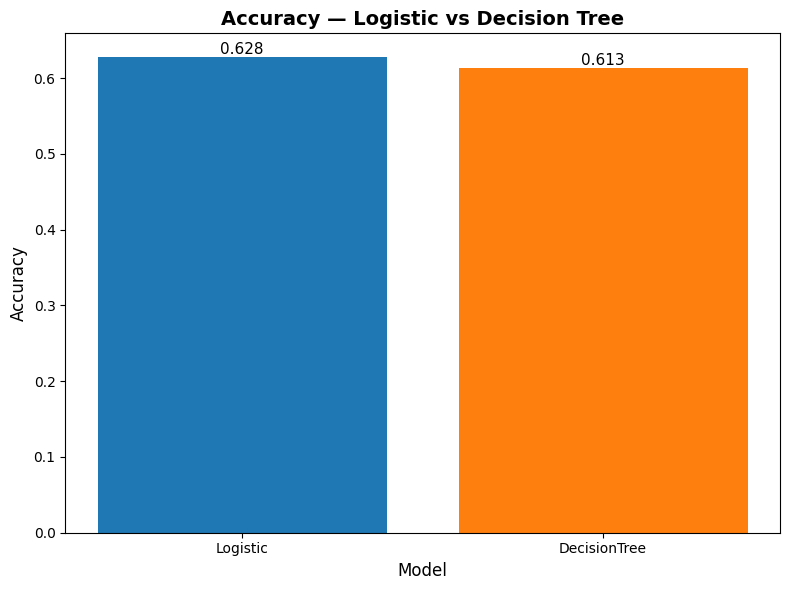

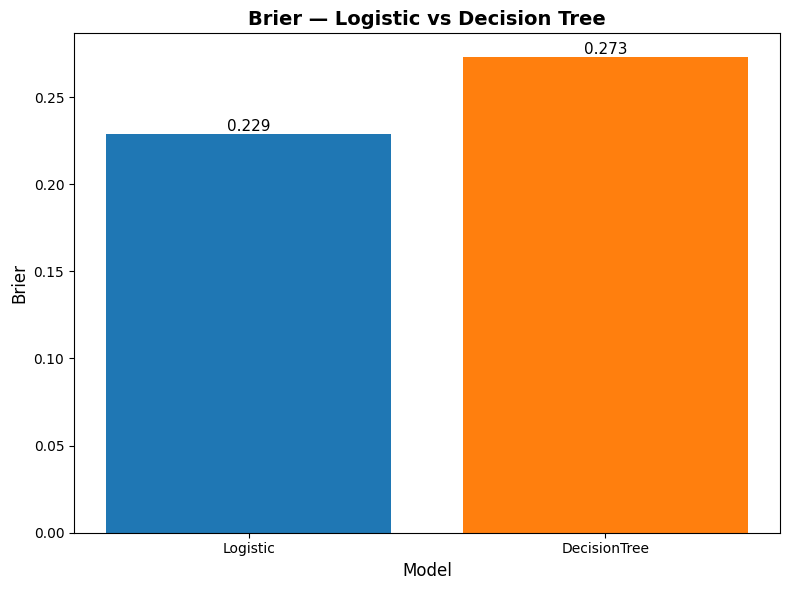

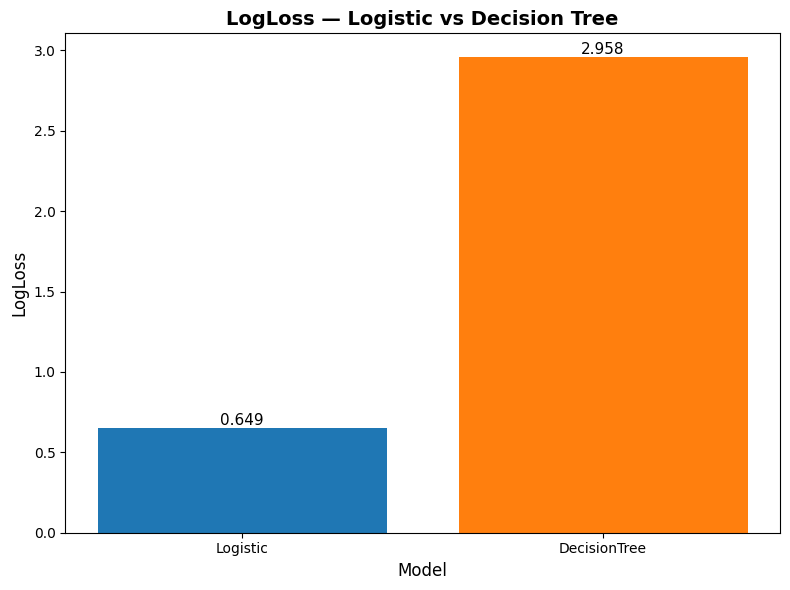

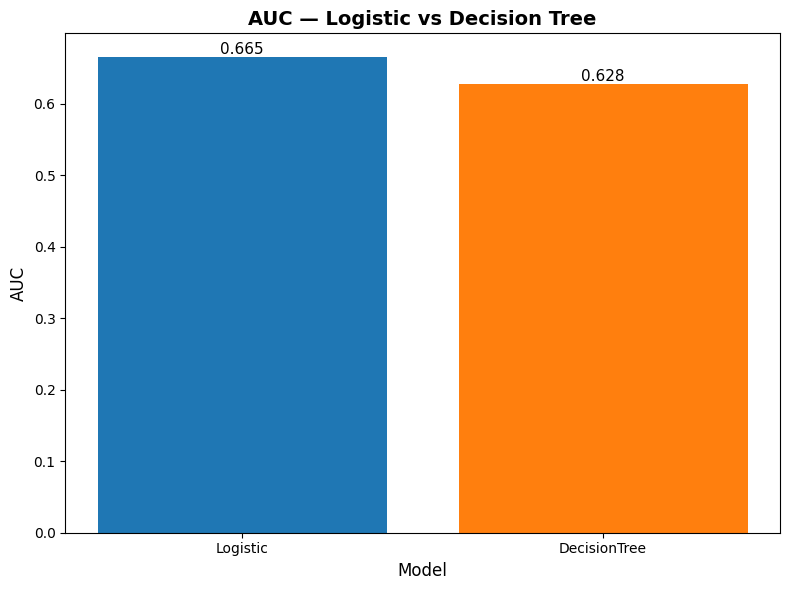

In [23]:
# Visual comparison (individual bar charts per metric)
import matplotlib.pyplot as plt

metrics = {
    'Accuracy':[acc_L, acc_T],
    'Brier':[brier_L, brier_T],
    'LogLoss':[ll_L, ll_T],
    'AUC':[auc_L, auc_T]
}
labels = ['Logistic','DecisionTree']

# Create individual figure for each metric
for m, vals in metrics.items():
    fig, ax = plt.subplots(figsize=(8, 6))
    bars = ax.bar(labels, vals, color=['#1f77b4', '#ff7f0e'])
    ax.set_title(f"{m} — Logistic vs Decision Tree", fontsize=14, fontweight='bold')
    ax.set_ylabel(m, fontsize=12)
    ax.set_xlabel("Model", fontsize=12)
    
    # Add value labels on each bar (rounded to 3 decimal places)
    for bar, val in zip(bars, vals):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.3f}',
                ha='center', va='bottom', fontsize=11)
    
    plt.tight_layout()
    plt.show()
